# Parse networks and outputs for 86 point alignment

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image as PImage

import menpo
import menpo.io as mio
import matplotlib.pyplot as plt
from menpo.shape import PointCloud
from menpo.transform import Translation, Scale
from menpofit.transform import DifferentiableAlignmentSimilarity

import networks
from flags import FLAGS

np.set_printoptions(3)
slim = tf.contrib.slim
%matplotlib inline

In [3]:
# printing
import detect_face_debug as detect_face

### MTCNN

In [4]:
minsize = 40 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor

with tf.Graph().as_default():
    sess = tf.Session()
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_detector(sess, './detection')

./detection/cas3.npy True


In [5]:
def crop_image_bounding_box(img, bbox, res, base=256., order=1, points=None):

    center = bbox.centre()
    bmin, bmax = bbox.bounds()
    scale = np.linalg.norm(bmax - bmin) / base
    print("center", center)
    print("minmax", bmin, bmax)
    print("scale", scale)
    print("init size", img.shape)

    return crop_image(img, center, scale, res, base, order=order, bmin=bmin, bmax=bmax, points=points)

def crop_image(img, center, scale, res, base=256., order=1, show=True, bmin=None, bmax=None, points=None):
    h = scale

    t = Translation(
        [
            res[0] * (-center[0] / h + .5),
            res[1] * (-center[1] / h + .5)
        ]).compose_after(Scale((res[0] / h, res[1] / h))).pseudoinverse()

    # Upper left point
    ul = np.floor(t.apply([0, 0]))
    # Bottom right point
    br = np.ceil(t.apply(res).astype(np.int))
    
    if show:
        plt.title("Original Image")
        plt.imshow(img.as_PILImage())

        ulbr = np.vstack((ul, br)).T
        plt.scatter(ulbr[1], ulbr[0])
        
        width, height = (br - ul).astype(np.int)
        p = plt.Rectangle(ul[::-1], height, width, fill=False,  color='g')
        plt.gca().add_patch(p)
        plt.text(*(br[::-1]), "crop dim", c='g')
        
        if points is not None:
            #pts = points.reshape(5,2).T
            pts =points.reshape(2,5)
            plt.scatter(pts[0], pts[1])
        
    if show and bmin is not None and bmax is not None:

        bminmax = np.vstack((bmin, bmax)).T
        print(bminmax)        
        
        width, height = (bmax - bmin)
        p = plt.Rectangle(bmin[::-1], height, width, fill=False, color='r')
        plt.gca().add_patch(p)
        plt.text(*(bmax[::-1]), "MTCNN box", c='r')

        plt.scatter(bminmax[1], bminmax[0], marker="x")
        plt.scatter(*(center[::-1]), marker="+", c='y')
        
        plt.show()
    
    # crop and rescale
    cimg, trans = img.warp_to_shape(
        br - ul, Translation(-(br - ul) / 2 + (br + ul) / 2), return_transform=True)
    if show:
        plt.title("Cropped Image, upper left %s bottom right %s"%(str(ul), str(br)))
        plt.imshow(cimg.as_PILImage())
        plt.show()
    c_scale = np.min(cimg.shape) / np.mean(res)
    new_img = cimg.rescale(1 / c_scale, order=order).resize(res, order=order)

    trans = trans.compose_after(Scale([c_scale, c_scale]))
    if show:
        plt.title("re sized %s"% str(new_img.shape))
        plt.imshow(new_img.as_PILImage())
        plt.show()
    
    return new_img, trans

def tf_heatmap_to_lms(heatmap):
    """
    take a heat map and 
    """
    hs = tf.argmax(tf.reduce_max(heatmap, 2), 1)
    ws = tf.argmax(tf.reduce_max(heatmap, 1), 1)
    print("heatmap", heatmap.shape)
    print("hs", hs.shape)
    print("ws", ws.shape)
    lms = tf.transpose(tf.to_float(tf.stack([hs, ws])), perm=[1, 2, 0])
    return lms

## init DNFaceMultiview

In [6]:
model_path = './ckpt/2D86/model.ckpt-217348'
template = mio.import_pickle('./image/template.pkl.gz')

n_landmarks = 86
FLAGS.n_landmarks = 86

with tf.Graph().as_default() as g:
    images_input = tf.placeholder(tf.float32, shape=(None, None, None, 3), name='input_images')
    net_model = networks.DNFaceMultiView('')
    
    with tf.variable_scope('net'):
        lms_heatmap_prediction, states = net_model._build_network(images_input, datas=None, is_training=False, 
                                                                 n_channels=n_landmarks)
        pts_predictions = tf_heatmap_to_lms(lms_heatmap_prediction)
        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config,graph=g)

saver.restore(sess, model_path)

/home/z/miniconda3/envs/abg10/lib/python3.6/site-packages/menpo/shape/labelled.py:212: MenpoDeprecationWarning: menpo.landmark.LandmarkGroup is now deprecated and has been moved to menpo.shape.LandmarkGroup.
  MenpoDeprecationWarning)


heatmap (?, ?, ?, 86)
hs (?, 86)
ws (?, 86)
INFO:tensorflow:Restoring parameters from ./ckpt/2D86/model.ckpt-217348


In [7]:
print("states", states[0].shape, type(states[0]))
print("lms_heatmap_prediction", lms_heatmap_prediction.shape, type(lms_heatmap_prediction))

states (?, ?, ?, 86) <class 'tensorflow.python.framework.ops.Tensor'>
lms_heatmap_prediction (?, ?, ?, 86) <class 'tensorflow.python.framework.ops.Tensor'>


In [8]:
print("pts_predictions", pts_predictions.shape, type(pts_predictions))

pts_predictions (?, 86, 2) <class 'tensorflow.python.framework.ops.Tensor'>


## show template used by dnfacemultiview

In [9]:
template.landmarks.keys()

KeysView(LandmarkManager: n_groups: 2
(PTS): LabelledPointUndirectedGraph: n_labels: 7, n_points: 68, n_edges: 63
(LJSON): LabelledPointUndirectedGraph: n_labels: 7, n_points: 84, n_edges: 79)

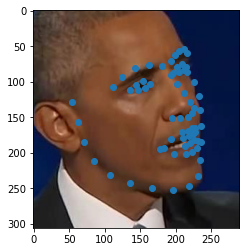

In [10]:
plt.imshow(template.as_PILImage())
#plt.scatter(template.landmarks['SAVEPTS'].points.T[0], template.landmarks['SAVEPTS'].points.T[1])
plt.scatter(template.landmarks['PTS'].points.T[1], template.landmarks['PTS'].points.T[0])
plt.show()

# left profile

### MTCNN face detector

Detect Face with MTCNN
First stage (PNET)
  scale: 0.3 	 (72, 96, 3) tensor shape (1, 96, 72, 3)
 out = pnet(tensor) [(1, 43, 31, 4), (1, 43, 31, 2)]
boxes (13, 9)
 boxes (13, 9)
 boxes after non minimum supression (5, 9)
  scale: 0.21269999999999997 	 (52, 69, 3) tensor shape (1, 69, 52, 3)
 out = pnet(tensor) [(1, 30, 21, 4), (1, 30, 21, 2)]
boxes (9, 9)
 boxes (9, 9)
 boxes after non minimum supression (9, 9)
  scale: 0.15080429999999997 	 (37, 49, 3) tensor shape (1, 49, 37, 3)
 out = pnet(tensor) [(1, 20, 14, 4), (1, 20, 14, 2)]
boxes (16, 9)
 boxes (16, 9)
 boxes after non minimum supression (15, 9)
  scale: 0.10692024869999997 	 (26, 35, 3) tensor shape (1, 35, 26, 3)
 out = pnet(tensor) [(1, 13, 8, 4), (1, 13, 8, 2)]
boxes (13, 9)
 boxes (13, 9)
 boxes after non minimum supression (19, 9)
  scale: 0.07580645632829998 	 (19, 25, 3) tensor shape (1, 25, 19, 3)
 out = pnet(tensor) [(1, 8, 5, 4), (1, 8, 5, 2)]
boxes (12, 9)
 boxes (12, 9)
 boxes after non minimum supression (23, 9)

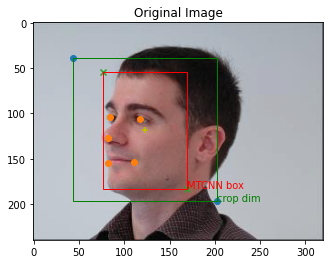

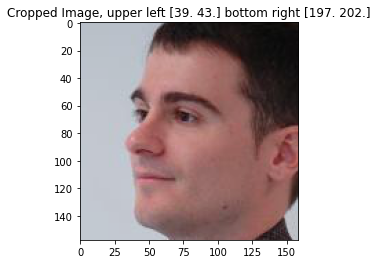

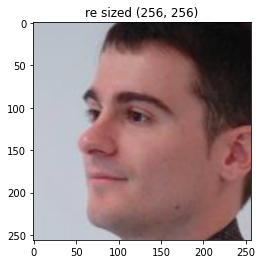

In [11]:
image_path = './image/ID01_004.jpg'
image = mio.import_image(image_path)  
image_path = image.path
image_ID_name = image_path.stem
bounding_boxes, points = detect_face.detect_face(image.pixels_with_channels_at_back() * 255, minsize, pnet, rnet, onet, threshold, factor)
print("bboxes", bounding_boxes.tolist())
print("points", points.tolist())
batch_pixels = []
batch_trans = []
batch_image_names = []

for box_index in np.arange(bounding_boxes.shape[0]):
    bbox = PointCloud(bounding_boxes[box_index,[1,0,3,2]].reshape([2,2])).bounding_box()
    crop_img, crop_trans = crop_image_bounding_box(image, bbox, [256., 256.], base=256./256., order=1, points=points)
    input_pixels = crop_img.pixels_with_channels_at_back()
    batch_pixels.append(input_pixels)
    batch_trans.append(crop_trans)
    batch_image_names.append('./image/' + image_ID_name + '__' + str(box_index) + '.pts')

## Landmarks: DNFace Multiview

### modify output to see heatmaps 

In [12]:
hm_pred = sess.run(
    lms_heatmap_prediction,
    feed_dict={images_input: np.stack(batch_pixels, axis=0)})


<function matplotlib.pyplot.show(*args, **kw)>

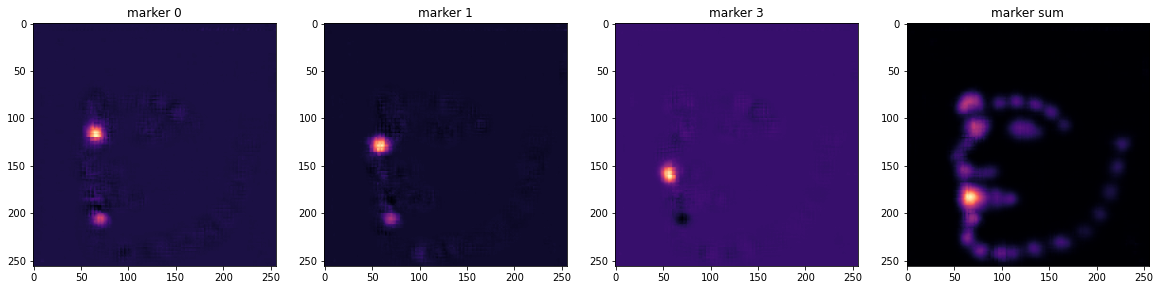

In [13]:
_hm_pred = hm_pred.transpose(3,1,2,0)[:,:,:,0]
plt.figure(figsize=(20,5))
plt.subplot(1,4,1);plt.title("marker 0")
plt.imshow(_hm_pred[0], cmap='magma')
plt.subplot(1,4,2);plt.title("marker 1")
plt.imshow(_hm_pred[1], cmap='magma')
plt.subplot(1,4,3);plt.title("marker 3")
plt.imshow(_hm_pred[3], cmap='magma')
plt.subplot(1,4,4);plt.title("marker sum")
plt.imshow(_hm_pred.sum(axis=0), cmap='magma')
plt.show

### markers

In [14]:
pts_pred = sess.run(
    pts_predictions,
    feed_dict={images_input: np.stack(batch_pixels, axis=0)})

for inner_batch_index in np.arange(bounding_boxes.shape[0]):
    orig_pts = batch_trans[inner_batch_index].apply(PointCloud(pts_pred[inner_batch_index]))
    template.landmarks['SAVEPTS'] = orig_pts
    mio.export_landmark_file(template.landmarks['SAVEPTS'], batch_image_names[inner_batch_index],extension='pts', overwrite=True)

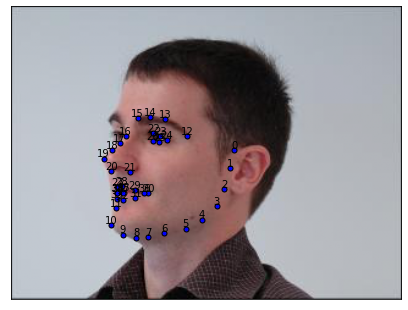

In [15]:
mask_index = np.array([17, 16, 15, 14, 13, 78, 79, 80, 81, 82, 83, 84, 27, 85, 86, 23,
                           28, 29, 30, 31, 34, 36, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 67])-1

image.view()
image.landmarks['PTS']= mio.import_landmark_file('./image/ID01_004__0.pts')

orig_pts = PointCloud((image.landmarks['PTS'].points[mask_index,0:2]))

orig_pts.view(marker_face_colour='b', render_numbering=True)

### lets see what menpo is plotting

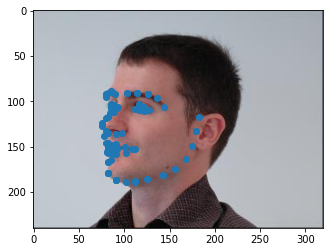

In [16]:
plt.imshow(PImage.open(image_path))
plt.scatter(image.landmarks['PTS'].points.T[1], image.landmarks['PTS'].points.T[0])

# right profile

In [17]:
image_path = './image/ID01_017.jpg'
image = mio.import_image(image_path)
print(image.shape)
img = np.array(PImage.open(image_path))
print(img.shape, type(img))
threshold, factor

(240, 320)
(240, 320, 3) <class 'numpy.ndarray'>


([0.6, 0.7, 0.7], 0.709)

Detect Face with MTCNN
First stage (PNET)
  scale: 0.3 	 (72, 96, 3) tensor shape (1, 96, 72, 3)
 out = pnet(tensor) [(1, 43, 31, 4), (1, 43, 31, 2)]
boxes (18, 9)
 boxes (18, 9)
 boxes after non minimum supression (7, 9)
  scale: 0.21269999999999997 	 (52, 69, 3) tensor shape (1, 69, 52, 3)
 out = pnet(tensor) [(1, 30, 21, 4), (1, 30, 21, 2)]
boxes (19, 9)
 boxes (19, 9)
 boxes after non minimum supression (11, 9)
  scale: 0.15080429999999997 	 (37, 49, 3) tensor shape (1, 49, 37, 3)
 out = pnet(tensor) [(1, 20, 14, 4), (1, 20, 14, 2)]
boxes (20, 9)
 boxes (20, 9)
 boxes after non minimum supression (19, 9)
  scale: 0.10692024869999997 	 (26, 35, 3) tensor shape (1, 35, 26, 3)
 out = pnet(tensor) [(1, 13, 8, 4), (1, 13, 8, 2)]
boxes (26, 9)
 boxes (26, 9)
 boxes after non minimum supression (26, 9)
  scale: 0.07580645632829998 	 (19, 25, 3) tensor shape (1, 25, 19, 3)
 out = pnet(tensor) [(1, 8, 5, 4), (1, 8, 5, 2)]
boxes (10, 9)
 boxes (10, 9)
 boxes after non minimum supression (29,

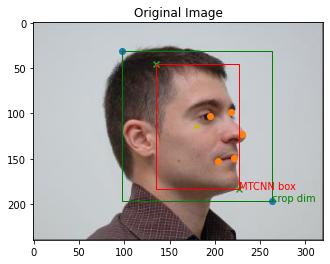

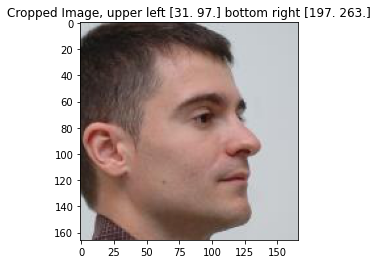

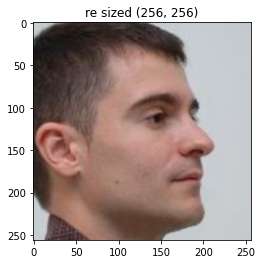

In [18]:
image_path = './image/ID01_017.jpg'
image = mio.import_image(image_path)  
image_path = image.path
image_ID_name = image_path.stem
bounding_boxes, points = detect_face.detect_face(image.pixels_with_channels_at_back() * 255, minsize, pnet, rnet, onet, threshold, factor)
print('Box Number: %s' % bounding_boxes.shape[0])
batch_pixels = []
batch_trans = []
batch_image_names = []

for box_index in np.arange(bounding_boxes.shape[0]):
    bbox = PointCloud(bounding_boxes[box_index,[1,0,3,2]].reshape([2,2])).bounding_box()
    crop_img, crop_trans = crop_image_bounding_box(image, bbox, [256., 256.], base=256./256., order=1, points=points)
    input_pixels = crop_img.pixels_with_channels_at_back()
    batch_pixels.append(input_pixels)
    batch_trans.append(crop_trans)
    batch_image_names.append('./image/' + image_ID_name + '__' + str(box_index) + '.pts')
    
pts_pred = sess.run(
    pts_predictions,
    feed_dict={images_input: np.stack(batch_pixels, axis=0)})

for inner_batch_index in np.arange(bounding_boxes.shape[0]):
    orig_pts = batch_trans[inner_batch_index].apply(PointCloud(pts_pred[inner_batch_index]))
    template.landmarks['SAVEPTS'] = orig_pts
    mio.export_landmark_file(template.landmarks['SAVEPTS'], batch_image_names[inner_batch_index],extension='pts', overwrite=True)

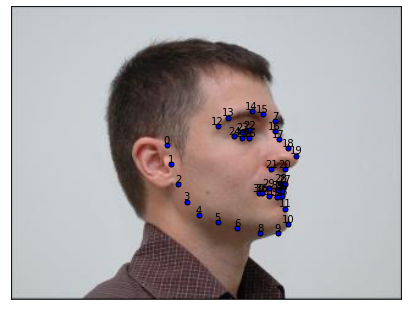

In [19]:
mask_index = np.array([1, 2, 3, 4, 5, 69, 70, 71, 72, 73, 74, 75, 18, 76, 77, 22,
                           28, 29, 30, 31, 34, 32, 39, 38, 37, 42, 41, 52, 51, 50, 49, 60, 59, 58, 63, 62, 61, 68, 67])-1

image.view()
image.landmarks['PTS']= mio.import_landmark_file(batch_image_names[0])

orig_pts = PointCloud((image.landmarks['PTS'].points[mask_index,0:2]))

orig_pts.view(marker_face_colour='b', render_numbering=True)

# frontal

Detect Face with MTCNN
First stage (PNET)
  scale: 0.3 	 (72, 96, 3) tensor shape (1, 96, 72, 3)
 out = pnet(tensor) [(1, 43, 31, 4), (1, 43, 31, 2)]
boxes (5, 9)
 boxes (5, 9)
 boxes after non minimum supression (3, 9)
  scale: 0.21269999999999997 	 (52, 69, 3) tensor shape (1, 69, 52, 3)
 out = pnet(tensor) [(1, 30, 21, 4), (1, 30, 21, 2)]
boxes (7, 9)
 boxes (7, 9)
 boxes after non minimum supression (7, 9)
  scale: 0.15080429999999997 	 (37, 49, 3) tensor shape (1, 49, 37, 3)
 out = pnet(tensor) [(1, 20, 14, 4), (1, 20, 14, 2)]
boxes (17, 9)
 boxes (17, 9)
 boxes after non minimum supression (14, 9)
  scale: 0.10692024869999997 	 (26, 35, 3) tensor shape (1, 35, 26, 3)
 out = pnet(tensor) [(1, 13, 8, 4), (1, 13, 8, 2)]
boxes (20, 9)
 boxes (20, 9)
 boxes after non minimum supression (20, 9)
  scale: 0.07580645632829998 	 (19, 25, 3) tensor shape (1, 25, 19, 3)
 out = pnet(tensor) [(1, 8, 5, 4), (1, 8, 5, 2)]
boxes (11, 9)
 boxes (11, 9)
 boxes after non minimum supression (23, 9)
 

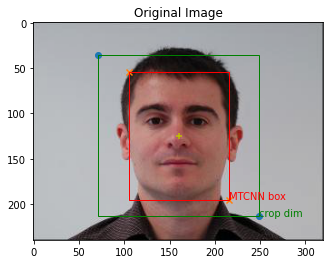

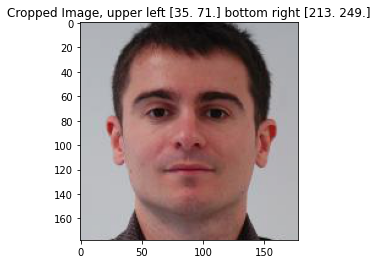

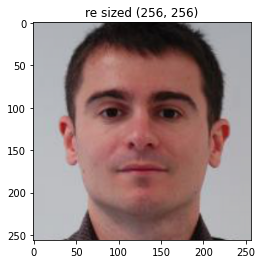

In [20]:
image_path = './image/ID01_001.jpg'
image = mio.import_image(image_path)  
image_path = image.path
image_ID_name = image_path.stem
bounding_boxes, points = detect_face.detect_face(image.pixels_with_channels_at_back() * 255, minsize, pnet, rnet, onet, threshold, factor)
print('Box Number: %s' % bounding_boxes.shape[0])
batch_pixels = []
batch_trans = []
batch_image_names = []

for box_index in np.arange(bounding_boxes.shape[0]):
    bbox = PointCloud(bounding_boxes[box_index,[1,0,3,2]].reshape([2,2])).bounding_box()
    crop_img, crop_trans = crop_image_bounding_box(image, bbox, [256., 256.], base=256./256., order=1)
    input_pixels = crop_img.pixels_with_channels_at_back()
    batch_pixels.append(input_pixels)
    batch_trans.append(crop_trans)
    batch_image_names.append('./image/' + image_ID_name + '__' + str(box_index) + '.pts')
    
pts_pred = sess.run(
    pts_predictions,
    feed_dict={images_input: np.stack(batch_pixels, axis=0)})

for inner_batch_index in np.arange(bounding_boxes.shape[0]):
    orig_pts = batch_trans[inner_batch_index].apply(PointCloud(pts_pred[inner_batch_index]))
    template.landmarks['SAVEPTS'] = orig_pts
    mio.export_landmark_file(template.landmarks['SAVEPTS'], batch_image_names[inner_batch_index],extension='pts', overwrite=True)

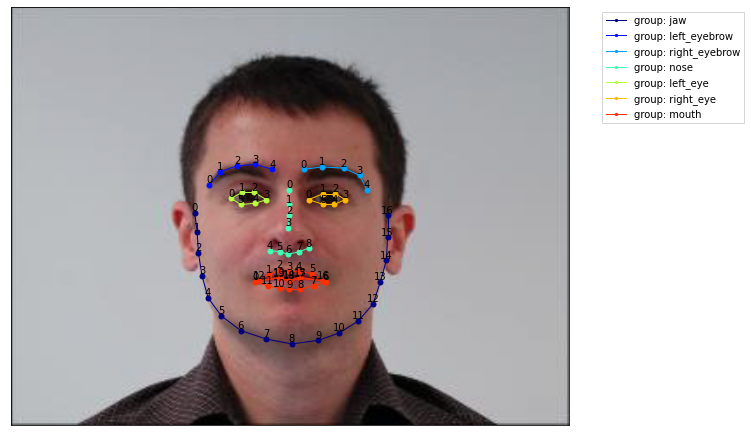

In [21]:
mask_index = np.arange(68)
image.view()
image.landmarks['PTS']= mio.import_landmark_file(batch_image_names[0])

template.landmarks['PTS'].points = image.landmarks['PTS'].points[mask_index,0:2]
lm = template.landmarks['PTS']
lm.view(marker_size=5,render_numbering=True)  